# Yelp Data Visualization

This notebook contains visualizations for the Yelp dataset using matplotlib and seaborn. We'll create various charts to explore patterns in business ratings, reviews, and user behavior.

## Import Libraries and Setup

In [4]:
! apt-get install libbz2-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libbz2-dev is already the newest version (1.0.8-4).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import json

# Set up matplotlib and seaborn styling
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Load Credentials and Initialize Spark

In [2]:
# Load credentials
with open("creds.json", "r") as f:
    creds = json.load(f)
    f.close()

print("Credentials loaded successfully!")

Credentials loaded successfully!


In [3]:
# Initialize Spark Session (if not already running)
try:
    spark = SparkSession.builder \
        .appName("YelpVisualization") \
        .master("spark://spark-master:7077") \
        .config("spark.driver.memory", "2g") \
        .config("spark.executor.memory", "2g") \
        .config("spark.executor.cores", "4") \
        .config("spark.worker.memory", "2g") \
        .config("spark.cores.max", "4") \
        .config("spark.hadoop.fs.s3a.access.key", creds["aws_client"]) \
        .config("spark.hadoop.fs.s3a.secret.key", creds["aws_secret"]) \
        .config("spark.jars.packages", 
                "org.apache.hadoop:hadoop-aws:3.3.4," + 
                "org.apache.hadoop:hadoop-common:3.3.4," +
                "com.amazonaws:aws-java-sdk-bundle:1.12.261," +
                "org.apache.logging.log4j:log4j-slf4j-impl:2.17.2," +
                "org.apache.logging.log4j:log4j-api:2.17.2," +
                "org.apache.logging.log4j:log4j-core:2.17.2," + 
                "org.apache.hadoop:hadoop-client:3.3.4," + 
                "io.delta:delta-core_2.12:2.4.0," + 
                "org.postgresql:postgresql:42.2.18") \
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
        .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
        .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        .getOrCreate()
    
    print("Spark session initialized successfully!")
    
except Exception as e:
    print(f"Error initializing Spark: {str(e)}")

:: loading settings :: url = jar:file:/usr/local/lib/python3.7/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
org.apache.hadoop#hadoop-common added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
org.apache.logging.log4j#log4j-slf4j-impl added as a dependency
org.apache.logging.log4j#log4j-api added as a dependency
org.apache.logging.log4j#log4j-core added as a dependency
org.apache.hadoop#hadoop-client added as a dependency
io.delta#delta-core_2.12 added as a dependency
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-78a8d325-a95d-44b6-876a-0303cb98ccd4;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.hadoop#hadoop-common;3.3.4 in central
	found org.apache.hadoop.thirdparty#hadoop-shaded-pr

Spark session initialized successfully!


## Load Yelp Data from Delta Tables

In [4]:
def read_delta(path: str):
    """Read a Delta table from S3 path"""
    try:
        df = spark.read \
            .format("delta") \
            .option("inferSchema", "true") \
            .load(path)
            
        print(f"Successfully read delta table from: {path}")
        print(f"Number of rows: {df.count()}")
        return df
        
    except Exception as e:
        print(f"Error reading delta table from {path}")
        print(f"Error: {str(e)}")
        return None

# Load data from S3 Delta tables
bucket = "yelp-stevenhurwitt-2"

business_df = read_delta(f"s3a://{bucket}/business")
review_df = read_delta(f"s3a://{bucket}/reviews")
user_df = read_delta(f"s3a://{bucket}/users")
checkin_df = read_delta(f"s3a://{bucket}/checkins")
tip_df = read_delta(f"s3a://{bucket}/tips")

25/08/18 03:08:21 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


Successfully read delta table from: s3a://yelp-stevenhurwitt-2/business


25/08/18 03:08:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Number of rows: 150346


Successfully read delta table from: s3a://yelp-stevenhurwitt-2/reviews


Number of rows: 6990280
Successfully read delta table from: s3a://yelp-stevenhurwitt-2/users


Number of rows: 1987897
Successfully read delta table from: s3a://yelp-stevenhurwitt-2/checkins


Number of rows: 131930
Successfully read delta table from: s3a://yelp-stevenhurwitt-2/tips
Number of rows: 908915


## Business Analysis Visualizations

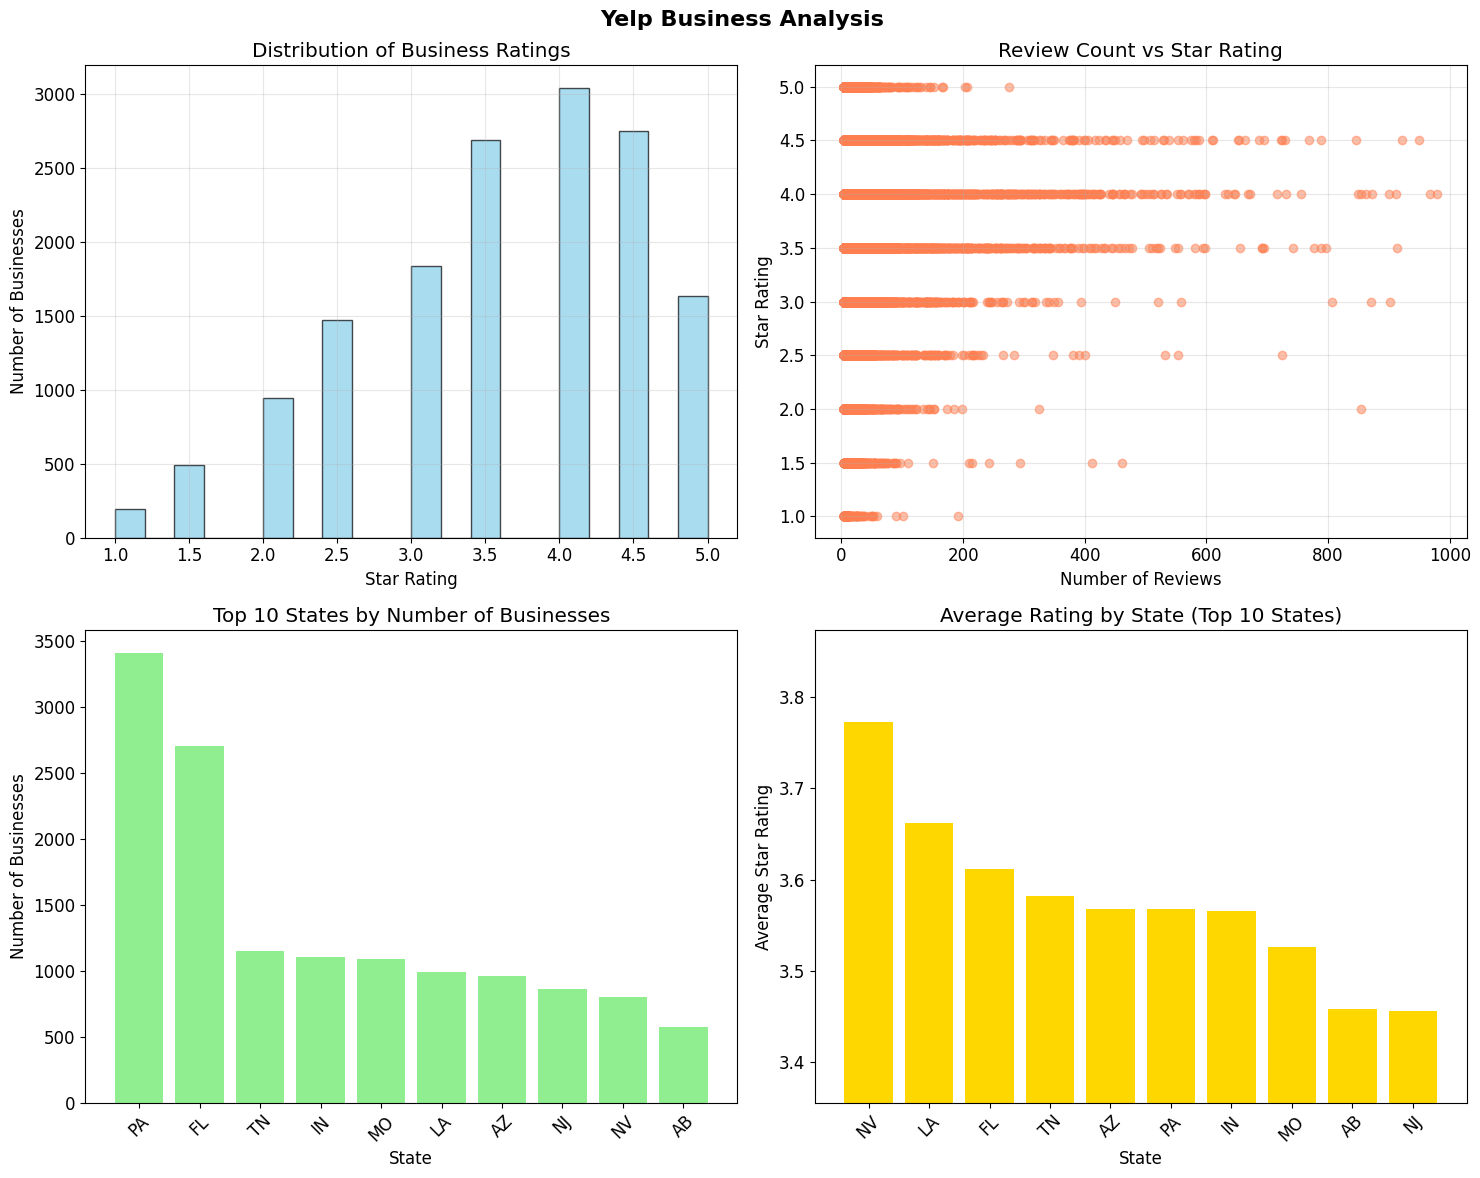

In [5]:
# Convert Spark DataFrames to Pandas for visualization
# Sample the data to make it manageable for visualization

# Business ratings distribution
business_pandas = business_df.select("stars", "review_count", "state", "city").sample(0.1).toPandas()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Yelp Business Analysis', fontsize=16, fontweight='bold')

# 1. Distribution of Business Ratings
axes[0, 0].hist(business_pandas['stars'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Business Ratings')
axes[0, 0].set_xlabel('Star Rating')
axes[0, 0].set_ylabel('Number of Businesses')
axes[0, 0].grid(True, alpha=0.3)

# 2. Review Count vs Rating
# Limit review count for better visualization
filtered_business = business_pandas[business_pandas['review_count'] <= 1000]
axes[0, 1].scatter(filtered_business['review_count'], filtered_business['stars'], alpha=0.5, color='coral')
axes[0, 1].set_title('Review Count vs Star Rating')
axes[0, 1].set_xlabel('Number of Reviews')
axes[0, 1].set_ylabel('Star Rating')
axes[0, 1].grid(True, alpha=0.3)

# 3. Top 10 States by Number of Businesses
state_counts = business_pandas['state'].value_counts().head(10)
axes[1, 0].bar(state_counts.index, state_counts.values, color='lightgreen')
axes[1, 0].set_title('Top 10 States by Number of Businesses')
axes[1, 0].set_xlabel('State')
axes[1, 0].set_ylabel('Number of Businesses')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Average Rating by State (top 10 states)
top_states = state_counts.head(10).index
avg_rating_by_state = business_pandas[business_pandas['state'].isin(top_states)].groupby('state')['stars'].mean().sort_values(ascending=False)
axes[1, 1].bar(avg_rating_by_state.index, avg_rating_by_state.values, color='gold')
axes[1, 1].set_title('Average Rating by State (Top 10 States)')
axes[1, 1].set_xlabel('State')
axes[1, 1].set_ylabel('Average Star Rating')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim([avg_rating_by_state.min() - 0.1, avg_rating_by_state.max() + 0.1])

plt.tight_layout()
plt.show()

## Review Analysis Visualizations

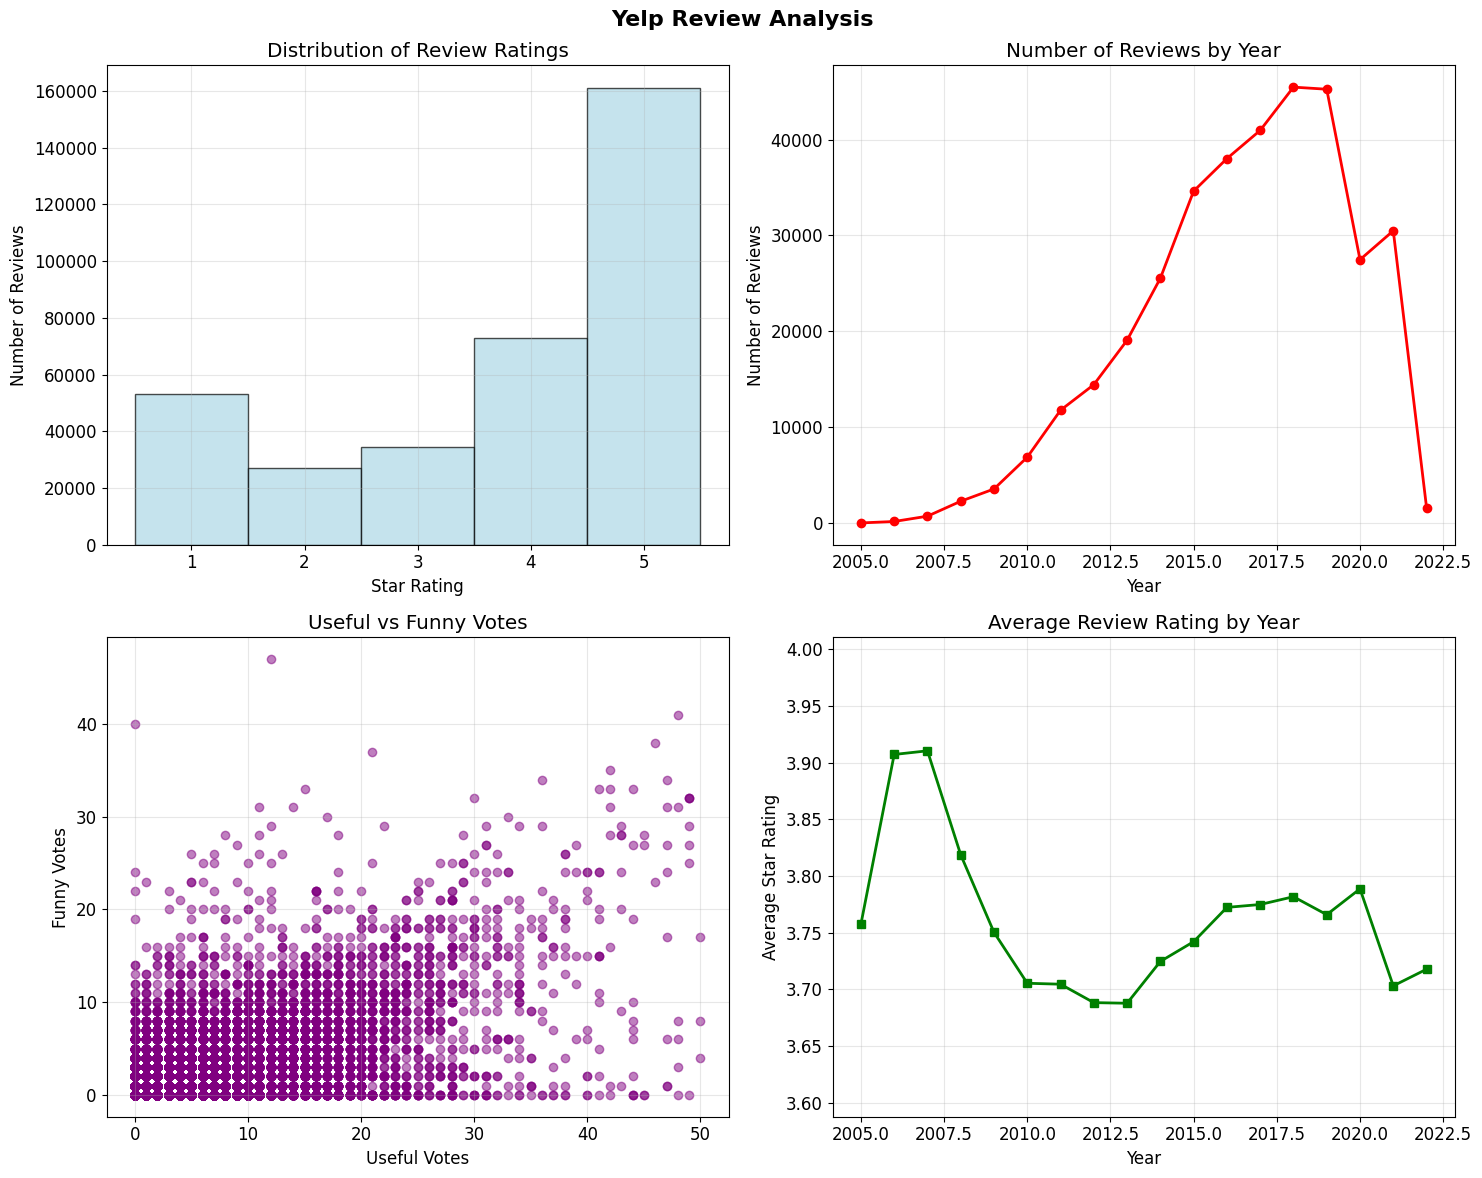

In [6]:
# Sample review data and add year column
review_sample = review_df.withColumn("year", year(col("date"))) \
    .select("stars", "useful", "funny", "cool", "year") \
    .sample(0.05) \
    .toPandas()

# Create subplots for review analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Yelp Review Analysis', fontsize=16, fontweight='bold')

# 1. Distribution of Review Ratings
axes[0, 0].hist(review_sample['stars'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], 
                alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Review Ratings')
axes[0, 0].set_xlabel('Star Rating')
axes[0, 0].set_ylabel('Number of Reviews')
axes[0, 0].set_xticks([1, 2, 3, 4, 5])
axes[0, 0].grid(True, alpha=0.3)

# 2. Reviews by Year
yearly_reviews = review_sample['year'].value_counts().sort_index()
axes[0, 1].plot(yearly_reviews.index, yearly_reviews.values, marker='o', linewidth=2, color='red')
axes[0, 1].set_title('Number of Reviews by Year')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Number of Reviews')
axes[0, 1].grid(True, alpha=0.3)

# 3. Useful vs Funny votes
# Filter out extreme outliers for better visualization
filtered_reviews = review_sample[(review_sample['useful'] <= 50) & (review_sample['funny'] <= 50)]
axes[1, 0].scatter(filtered_reviews['useful'], filtered_reviews['funny'], alpha=0.5, color='purple')
axes[1, 0].set_title('Useful vs Funny Votes')
axes[1, 0].set_xlabel('Useful Votes')
axes[1, 0].set_ylabel('Funny Votes')
axes[1, 0].grid(True, alpha=0.3)

# 4. Average rating by year
avg_rating_by_year = review_sample.groupby('year')['stars'].mean()
axes[1, 1].plot(avg_rating_by_year.index, avg_rating_by_year.values, 
                marker='s', linewidth=2, color='green')
axes[1, 1].set_title('Average Review Rating by Year')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Average Star Rating')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([avg_rating_by_year.min() - 0.1, avg_rating_by_year.max() + 0.1])

plt.tight_layout()
plt.show()

## User Analysis Visualizations

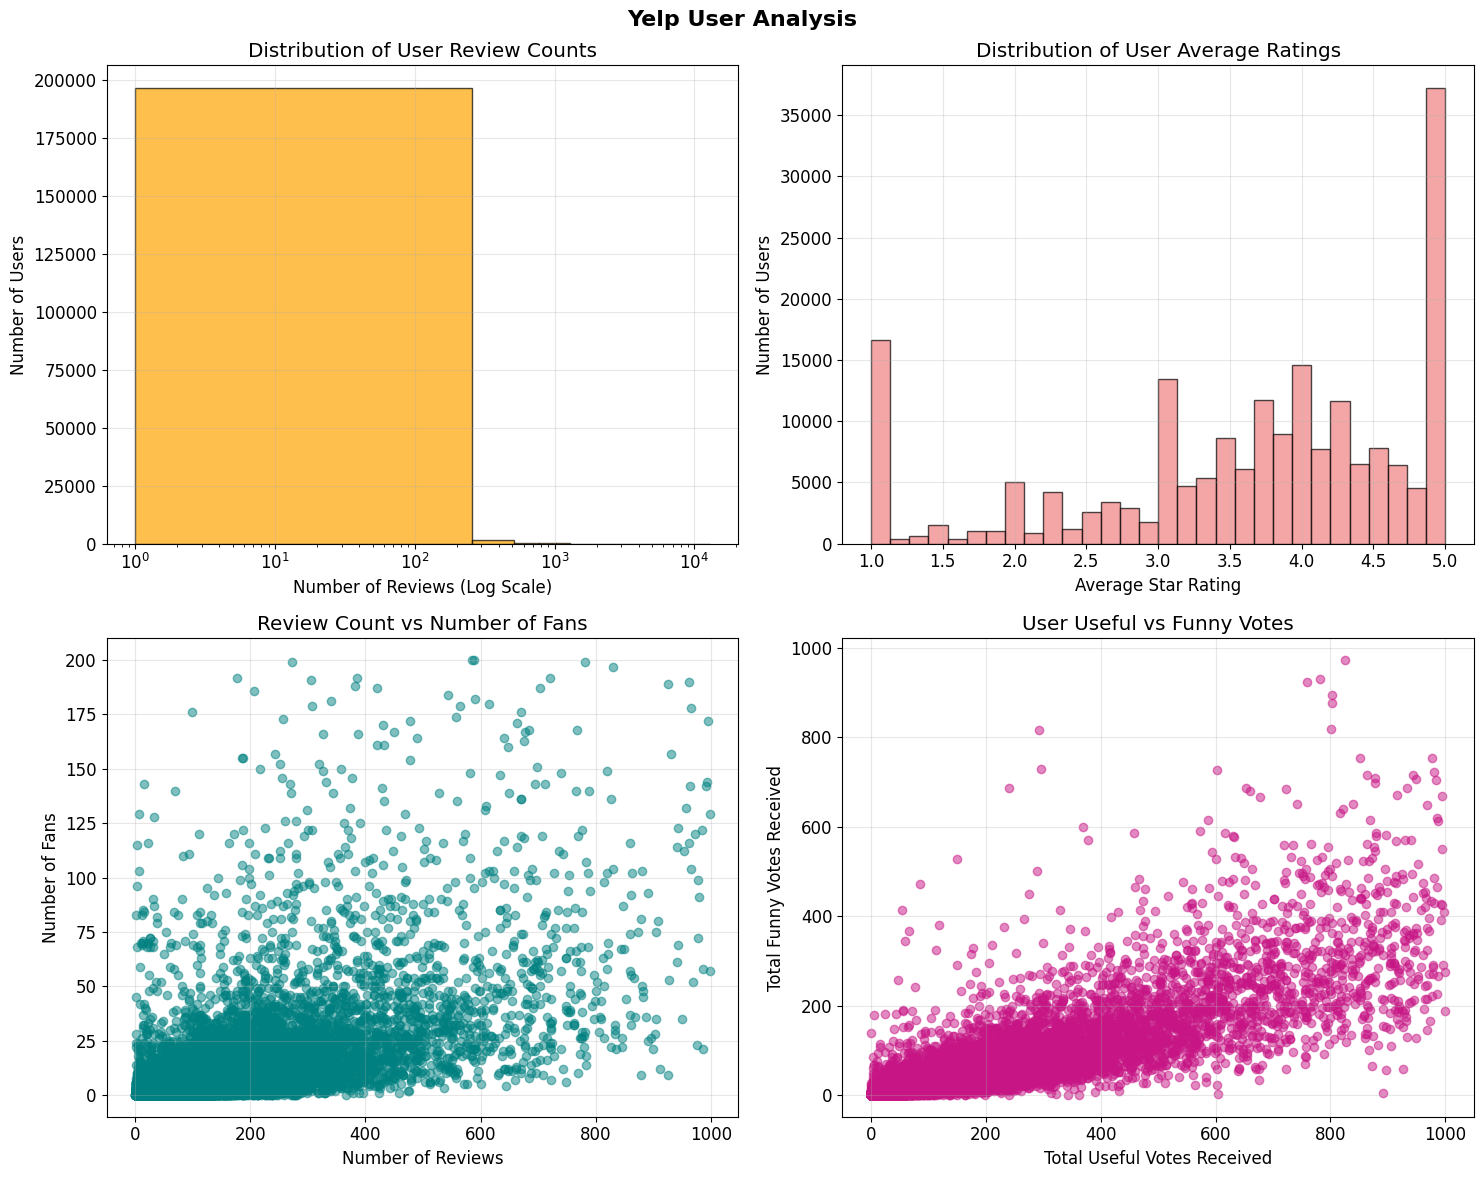

In [7]:
# Sample user data
user_sample = user_df.select("review_count", "useful", "funny", "cool", "fans", "average_stars") \
    .sample(0.1) \
    .toPandas()

# Create subplots for user analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Yelp User Analysis', fontsize=16, fontweight='bold')

# 1. Distribution of User Review Counts (log scale)
# Filter out users with 0 reviews for log scale
user_reviews = user_sample[user_sample['review_count'] > 0]['review_count']
axes[0, 0].hist(user_reviews, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 0].set_title('Distribution of User Review Counts')
axes[0, 0].set_xlabel('Number of Reviews (Log Scale)')
axes[0, 0].set_ylabel('Number of Users')
axes[0, 0].set_xscale('log')
axes[0, 0].grid(True, alpha=0.3)

# 2. User Average Stars Distribution
axes[0, 1].hist(user_sample['average_stars'].dropna(), bins=30, alpha=0.7, 
                color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of User Average Ratings')
axes[0, 1].set_xlabel('Average Star Rating')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].grid(True, alpha=0.3)

# 3. Review Count vs Fans (limited to reasonable ranges)
filtered_users = user_sample[(user_sample['review_count'] <= 1000) & (user_sample['fans'] <= 200)]
axes[1, 0].scatter(filtered_users['review_count'], filtered_users['fans'], alpha=0.5, color='teal')
axes[1, 0].set_title('Review Count vs Number of Fans')
axes[1, 0].set_xlabel('Number of Reviews')
axes[1, 0].set_ylabel('Number of Fans')
axes[1, 0].grid(True, alpha=0.3)

# 4. Useful votes vs Funny votes for users
filtered_users_votes = user_sample[(user_sample['useful'] <= 1000) & (user_sample['funny'] <= 1000)]
axes[1, 1].scatter(filtered_users_votes['useful'], filtered_users_votes['funny'], 
                   alpha=0.5, color='mediumvioletred')
axes[1, 1].set_title('User Useful vs Funny Votes')
axes[1, 1].set_xlabel('Total Useful Votes Received')
axes[1, 1].set_ylabel('Total Funny Votes Received')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Combined Analysis: Restaurant Focus

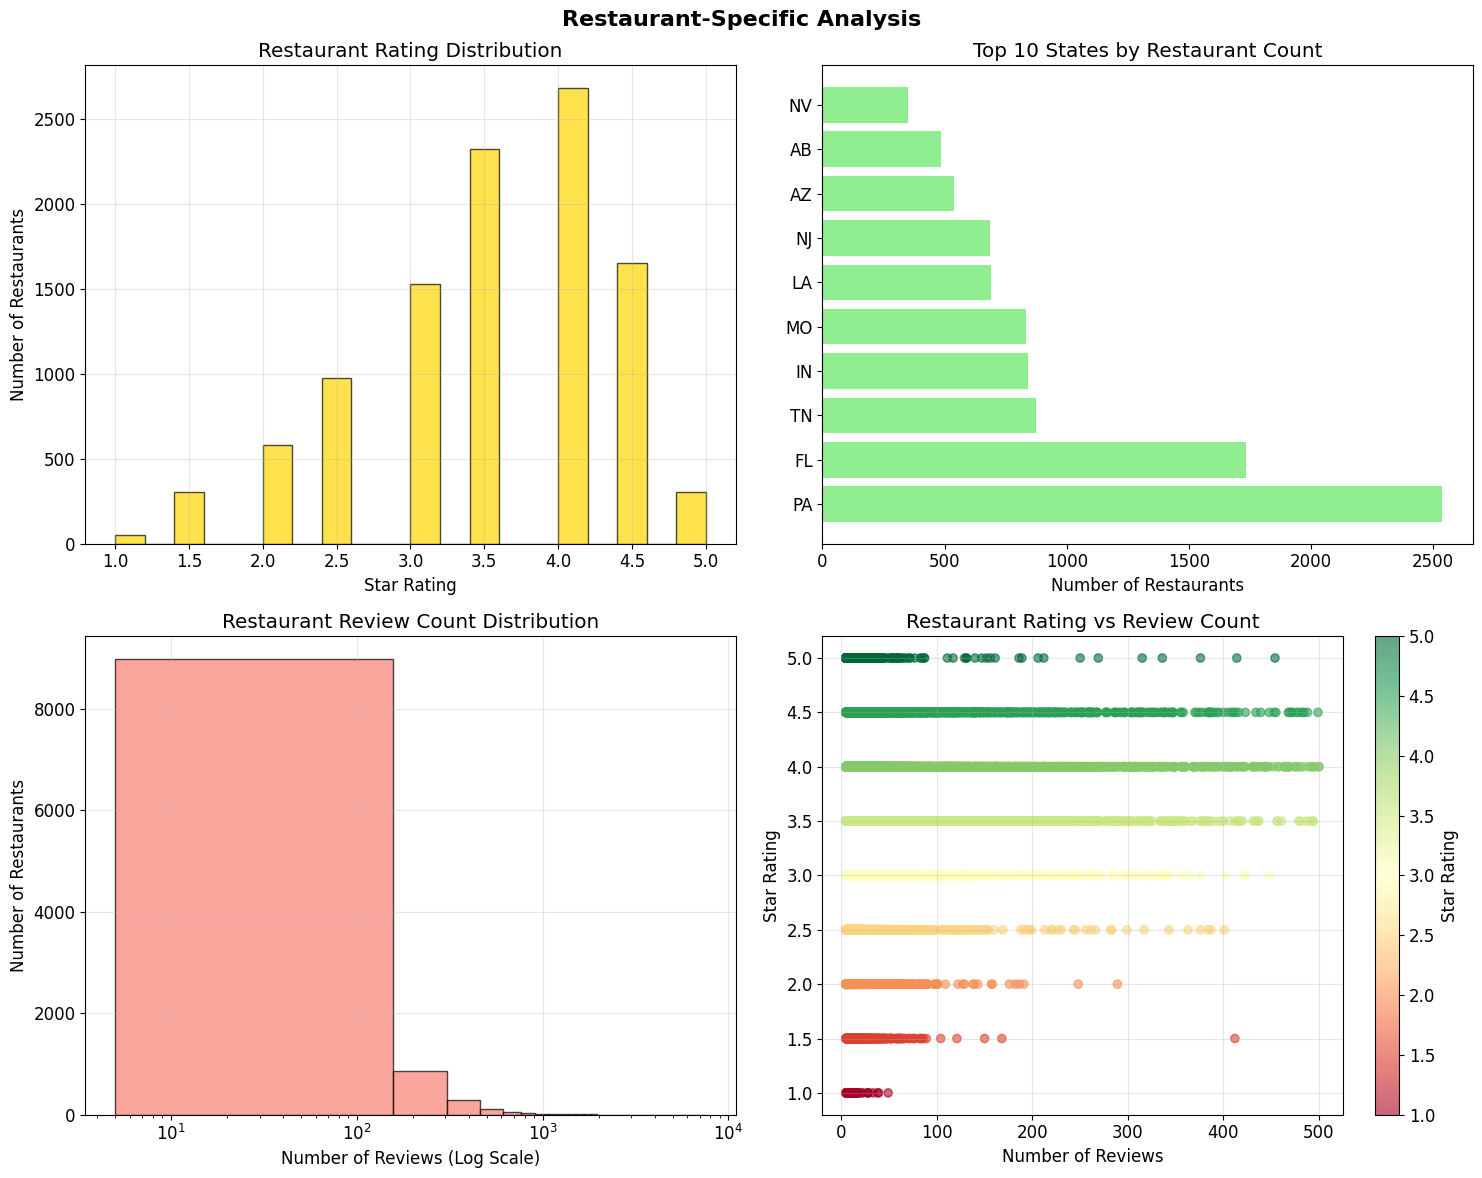

In [8]:
# Focus on restaurants specifically
restaurants_df = business_df.filter(col("categories").contains("Restaurants")) \
    .select("business_id", "name", "stars", "review_count", "state", "city", "categories")

# Sample restaurant data
restaurants_sample = restaurants_df.sample(0.2).toPandas()

# Create restaurant-focused visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Restaurant-Specific Analysis', fontsize=16, fontweight='bold')

# 1. Restaurant Rating Distribution
axes[0, 0].hist(restaurants_sample['stars'], bins=20, alpha=0.7, color='gold', edgecolor='black')
axes[0, 0].set_title('Restaurant Rating Distribution')
axes[0, 0].set_xlabel('Star Rating')
axes[0, 0].set_ylabel('Number of Restaurants')
axes[0, 0].grid(True, alpha=0.3)

# 2. Top States for Restaurants
restaurant_states = restaurants_sample['state'].value_counts().head(10)
axes[0, 1].barh(range(len(restaurant_states)), restaurant_states.values, color='lightgreen')
axes[0, 1].set_yticks(range(len(restaurant_states)))
axes[0, 1].set_yticklabels(restaurant_states.index)
axes[0, 1].set_title('Top 10 States by Restaurant Count')
axes[0, 1].set_xlabel('Number of Restaurants')

# 3. Review Count Distribution for Restaurants
# Use log scale for better visualization
restaurant_reviews = restaurants_sample[restaurants_sample['review_count'] > 0]['review_count']
axes[1, 0].hist(restaurant_reviews, bins=50, alpha=0.7, color='salmon', edgecolor='black')
axes[1, 0].set_title('Restaurant Review Count Distribution')
axes[1, 0].set_xlabel('Number of Reviews (Log Scale)')
axes[1, 0].set_ylabel('Number of Restaurants')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

# 4. Rating vs Review Count for Restaurants
filtered_restaurants = restaurants_sample[restaurants_sample['review_count'] <= 500]
scatter = axes[1, 1].scatter(filtered_restaurants['review_count'], filtered_restaurants['stars'], 
                            alpha=0.6, c=filtered_restaurants['stars'], cmap='RdYlGn', 
                            vmin=1, vmax=5)
axes[1, 1].set_title('Restaurant Rating vs Review Count')
axes[1, 1].set_xlabel('Number of Reviews')
axes[1, 1].set_ylabel('Star Rating')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='Star Rating')

plt.tight_layout()
plt.show()

## Summary Statistics

In [9]:
# Print summary statistics
print("=== YELP DATASET SUMMARY ===")
print(f"Total Businesses: {business_df.count():,}")
print(f"Total Reviews: {review_df.count():,}")
print(f"Total Users: {user_df.count():,}")
print(f"Total Tips: {tip_df.count():,}")
print(f"Total Checkins: {checkin_df.count():,}")

# Restaurant-specific stats
restaurant_count = restaurants_df.count()
print(f"\nTotal Restaurants: {restaurant_count:,}")
print(f"Restaurant Percentage of All Businesses: {(restaurant_count / business_df.count() * 100):.1f}%")

# Average ratings
avg_business_rating = business_df.agg(avg("stars")).collect()[0][0]
avg_review_rating = review_df.agg(avg("stars")).collect()[0][0]
print(f"\nAverage Business Rating: {avg_business_rating:.2f}")
print(f"Average Review Rating: {avg_review_rating:.2f}")

=== YELP DATASET SUMMARY ===
Total Businesses: 150,346
Total Reviews: 6,990,280
Total Users: 1,987,897
Total Tips: 908,915
Total Checkins: 131,930



Total Restaurants: 52,268
Restaurant Percentage of All Businesses: 34.8%



Average Business Rating: 3.60
Average Review Rating: 3.75
